In [2]:

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input,Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Model

In [3]:
#Reading the dataset
data=pd.read_csv("labels.txt", sep=" ", names=['image','attr1','attr2','attr3','attr4'])
data

,image,attr1,attr2,attr3,attr4
0,image_0.jpg,1.0,NaN,0.0,1.0
1,image_1.jpg,NaN,0.0,0.0,0.0
2,image_2.jpg,1.0,1.0,0.0,0.0
3,image_3.jpg,1.0,1.0,0.0,0.0
4,image_4.jpg,1.0,1.0,0.0,0.0
...,...,...,...,...,...
970,image_970.jpg,1.0,1.0,1.0,1.0
971,image_971.jpg,1.0,1.0,0.0,0.0
972,image_972.jpg,1.0,NaN,1.0,0.0
973,image_973.jpg,0.0,1.0,0.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   975 non-null    object 
 1   attr1   895 non-null    float64
 2   attr2   884 non-null    float64
 3   attr3   882 non-null    float64
 4   attr4   881 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.2+ KB


In [5]:
data.describe()

,attr1,attr2,attr3,attr4
count,895.000000,884.000000,882.000000,881.000000
mean,0.881564,0.806561,0.528345,0.077185
std,0.323304,0.395218,0.499479,0.267036
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [6]:
#Missing values in dataset
for col_name in data.columns: 
    print ("column:",col_name,".Missing:",sum(data[col_name].isnull()))

column: image .Missing: 0
column: attr1 .Missing: 80
column: attr2 .Missing: 91
column: attr3 .Missing: 93
column: attr4 .Missing: 94


In [7]:
#Handling missing values using the most robust imputer--> Knn imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_attr = imputer.fit_transform(data[["attr1","attr2","attr3","attr4"]])
data_attr = np.where(data_attr >= 0.5, 1, 0)
data_attr=pd.DataFrame(data_attr, columns=["attr1","attr2","attr3","attr4"])
for col_name in data_attr.columns: 
    print ("column:",col_name,".Missing:",sum(data_attr[col_name].isnull()))


column: attr1 .Missing: 0
column: attr2 .Missing: 0
column: attr3 .Missing: 0
column: attr4 .Missing: 0


array([<AxesSubplot:title={'center':'attr4'}>], dtype=object)

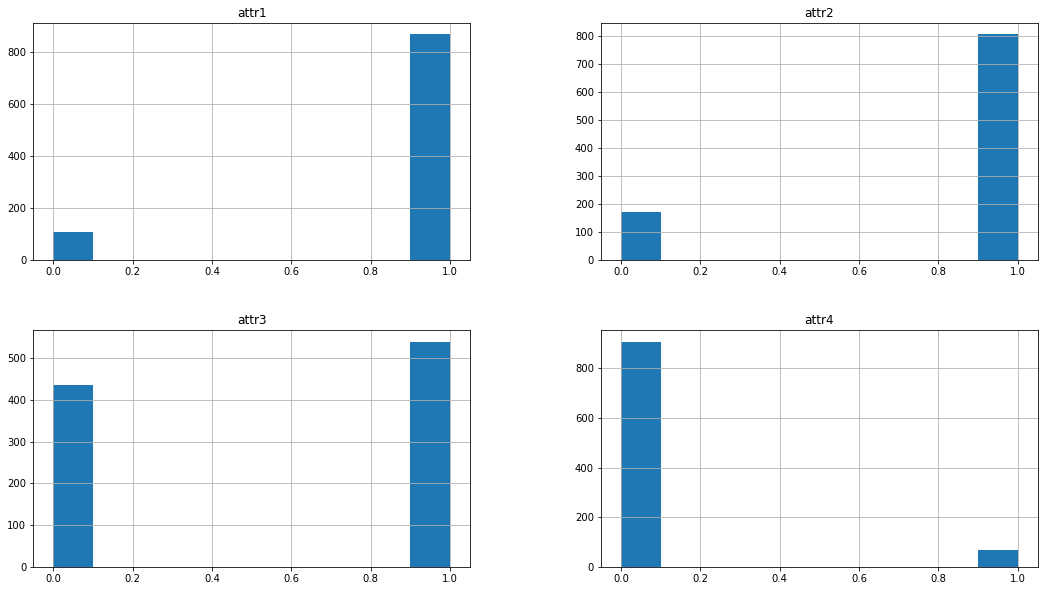

In [8]:
#Data set is imbalanced 
fig, axes = plt.subplots(2,2, figsize=(18, 10))
data_attr.hist('attr1',ax=axes[0,0])
data_attr.hist('attr2',ax=axes[0,1])
data_attr.hist('attr3',ax=axes[1,0])
data_attr.hist('attr4',ax=axes[1,1])

In [9]:
#using Transfer learning VGG16 architecuture 
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [10]:
for layer in vgg.layers:
  layer.trainable = False

In [11]:
x = Flatten()(vgg.output)
prediction = Dense(4, activation='sigmoid')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
#Reading image from the folder and saving as array values
image_directory = 'images/'
X_dataset = []  
for i in tqdm(range(data.shape[0])):
    img = image.load_img(image_directory+data['image'][i], target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255.
    X_dataset.append(img)
    
X = np.array(X_dataset)
print(X.shape)

100%|██████████| 975/975 [00:07<00:00, 136.66it/s]


(975, 224, 224, 3)


In [13]:
y=np.array(data_attr)
print(y.shape)

(975, 4)


In [14]:
#split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [15]:

history = model.fit(X_train, y_train, epochs=11, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/11
11/11 [==============================] - 62s 6s/step - loss: 0.8036 - accuracy: 0.7361 - val_loss: 0.5940 - val_accuracy: 0.1297
Epoch 2/11
11/11 [==============================] - 61s 6s/step - loss: 0.5051 - accuracy: 0.5367 - val_loss: 0.5099 - val_accuracy: 0.9078
Epoch 3/11
11/11 [==============================] - 61s 6s/step - loss: 0.3636 - accuracy: 0.6378 - val_loss: 0.4820 - val_accuracy: 0.7645
Epoch 4/11
11/11 [==============================] - 61s 6s/step - loss: 0.2865 - accuracy: 0.7551 - val_loss: 0.4766 - val_accuracy: 0.6655
Epoch 5/11
11/11 [==============================] - 61s 6s/step - loss: 0.2422 - accuracy: 0.7478 - val_loss: 0.4740 - val_accuracy: 0.7133
Epoch 6/11
11/11 [==============================] - 61s 6s/step - loss: 0.2099 - accuracy: 0.7610 - val_loss: 0.4871 - val_accuracy: 0.5427
Epoch 7/11
11/11 [==============================] - 62s 6s/step - loss: 0.1848 - accuracy: 0.7493 - val_loss: 0.5163 - val_accuracy: 0.8601
Epoch 8/11
11/11 [==

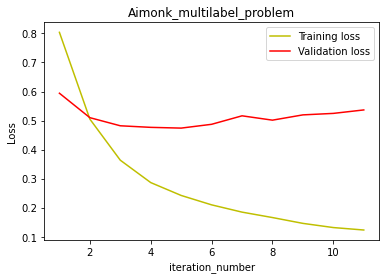

In [25]:
#Graph for traning loss and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Aimonk_multilabel_problem')
plt.xlabel('iteration_number')
plt.ylabel('Loss')
plt.legend()
plt.show()

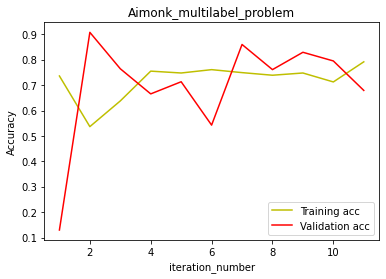

In [26]:
#Graph for traning acuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Aimonk_multilabel_problem')
plt.xlabel('iteration_number')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
history.history

{'loss': [0.8036452531814575,
  0.5050694346427917,
  0.3635631501674652,
  0.286507248878479,
  0.24221278727054596,
  0.20985208451747894,
  0.1848023533821106,
  0.16612452268600464,
  0.14608053863048553,
  0.13168753683567047,
  0.12325561791658401],
 'accuracy': [0.7360703945159912,
  0.53665691614151,
  0.6378298997879028,
  0.7551319599151611,
  0.7478005886077881,
  0.7609970569610596,
  0.7492668628692627,
  0.7390029430389404,
  0.7478005886077881,
  0.7126099467277527,
  0.7917888760566711],
 'val_loss': [0.5940465927124023,
  0.5099440813064575,
  0.482014536857605,
  0.47659704089164734,
  0.47401726245880127,
  0.487093448638916,
  0.5163125395774841,
  0.501356303691864,
  0.5195438265800476,
  0.5246530175209045,
  0.5365662574768066],
 'val_accuracy': [0.12969283759593964,
  0.9078498482704163,
  0.76450514793396,
  0.6655290126800537,
  0.7133105993270874,
  0.5426621437072754,
  0.8600682616233826,
  0.7610921263694763,
  0.829351544380188,
  0.7952218651771545,
  0

1/1 [==============================] - 0s 106ms/step
Attribute Classification for the given image: [1 1 1 0]


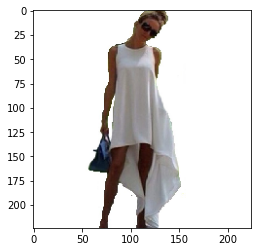

In [27]:
#inference code which takes in an image as input and prints the list of attributes present in that image
img = image.load_img('images/image_19.jpg', target_size=(224,224,3))
img = image.img_to_array(img)
img = img/255.
plt.imshow(img)
img = np.expand_dims(img, axis=0)
classes = np.array(data.columns[1:]) #Get array of all classes
result = model.predict(img) #Get probabilities for each class

result = np.where(result>=0.5, 1, 0)
print("Attribute Classification for the given image:" ,result[0])

In [28]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

10/10 [==============================] - 20s 2s/step - loss: 0.5366 - accuracy: 0.6792
Accuracy =  67.91808605194092 %


In [29]:
from tensorflow.keras.models import save_model,load_model

#model saved in local system
save_model(model, "model.h5")
model_saved = load_model('model.h5')
result=model_saved.predict(img)
result = np.where(result>=0.5, 1, 0)
print("Attribute Classification for the given image:" ,result[0])

1/1 [==============================] - 0s 206ms/step
Attribute Classification for the given image: [1 1 1 0]


In [30]:
#deep-model file containing weights
model.save_weights("model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
model.get_weights()

[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
          [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
           -9.431

In [107]:
 #Handling imbalanced data using data augumentation
 
 datagen = ImageDataGenerator(rescale = 1./255,
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip = True,
                              featurewise_center=True, )
 # specify imagenet mean values for centering
 datagen.mean = [123.68, 116.779, 103.939]
 # prepare iterators
 train_it = datagen.flow( X_train, y_train, batch_size=16)
 test_it = datagen.flow(X_test, y_test, batch_size=16)
 # define model
 history1 = model.fit_generator(train_it, steps_per_epoch=len(train_it),
 validation_data=test_it, validation_steps=len(test_it), epochs=11, verbose=0)
 # evaluate model
 loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
 print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

C:\Users\sowmu\AppData\Local\Temp\ipykernel_34236\91340531.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model.fit_generator(train_it, steps_per_epoch=len(train_it),
C:\Users\sowmu\AppData\Local\Temp\ipykernel_34236\91340531.py:17: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


> loss=0.647, fbeta=0.085
